<a href="https://colab.research.google.com/github/katL7/GTSRB-APS360/blob/Finally_got_the_model_to_train_with_features/APS360_Traffic_Sign_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from google.colab import drive
import os
import matplotlib.pyplot as plt

In [ ]:
use_cuda = True

##Test Change

## Dataset

In [ ]:
# split into training, validation and test - stratify each
def get_val_test_loader(batch_size=64, img_size=50):
    # Rescale images to all be the same size
    data_transform = transforms.Compose([transforms.Resize((img_size,img_size)), 
                                         transforms.ToTensor()])

    # Get paths to data in folder
    gtsrb_data = datasets.GTSRB('data', download=True, split='test',
                           transform=data_transform)

    class_idxs = {}
    #Loop through filenames and sort into classes
    for i, data in enumerate(gtsrb_data):
        img, label = data
        if label in class_idxs:
          class_idxs[label].append(i)
        else:
          class_idxs[label] = [i]

    np.random.seed(1000)
    test_indices = []
    val_indices = []

    for class_key in class_idxs:
      #Split validation/testing indices as 0.7/0.3 split by class
      np.random.shuffle(class_idxs[class_key])
      split = int(len(class_idxs[class_key]) * 0.7)
      val_indices += class_idxs[class_key][:split]
      test_indices += class_idxs[class_key][split:]

    #Shuffle the testing/validation indices
    np.random.shuffle(test_indices)
    np.random.shuffle(val_indices)

    #testing data loader
    test_sampler = SubsetRandomSampler(test_indices)
    test_loader = torch.utils.data.DataLoader(gtsrb_data, batch_size=batch_size,
          num_workers=0, sampler=test_sampler)

    #Validation data loader
    val_sampler = SubsetRandomSampler(val_indices)
    val_loader = torch.utils.data.DataLoader(gtsrb_data, batch_size=batch_size,
          num_workers=0, sampler=val_sampler)
    
    return val_loader, test_loader

In [33]:
def get_train_loader(batch_size=64, img_size=50):
    # Rescale images to all be the same size
    data_transform = transforms.Compose([transforms.Resize((img_size,img_size)), 
                                         transforms.ToTensor()])

    # Get paths to data in folder
    data = datasets.GTSRB('data', download=True, split="train",
                          transform=data_transform)
  
    np.random.seed(1000)
    #train data loader
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
          num_workers=0, shuffle=True)
    
    return train_loader



In [ ]:
val_loader, test_loader = get_val_test_loader(64)

[5806, 557, 11070, 1547, 8577, 501, 1688, 2955, 4054, 10100, 5121, 9581, 11459, 6534, 5480, 10975, 12407, 12534, 10311, 12266, 5909, 2256, 3693, 3809, 2382, 10042, 11241, 10929, 740, 6525, 6755, 10437, 12155, 985, 5975, 10681, 5456, 1999, 147, 5004, 3474, 2459, 11486, 4087, 497, 11978, 9532, 8427, 6703, 12520, 10642, 7289, 4440, 4012, 9190, 11183, 12364, 8653, 310, 8724, 4715, 2473, 1722, 5206, 10776, 2967, 12455, 3520, 9938, 3242, 3527, 8042, 12, 893, 4240, 7133, 9771, 3320, 6190, 11642, 3613, 10690, 10173, 3637, 384, 9396, 9629, 11928, 6057, 3299, 10602, 8791, 6863, 9833, 8769, 137, 4854, 5458, 1112, 9047, 1532, 12552, 5037, 8258, 8840, 1150, 736, 7620, 10668, 4933, 7835, 7605, 4387, 1741, 1668, 7920, 2025, 9829, 7772, 8541, 3824, 3249, 2851, 4358, 8287, 1363, 12276, 4114, 4531, 9554, 2122, 12003, 8742, 5848, 10722, 12283, 8397, 8700, 7275, 11838, 12303, 9477, 7420, 7050, 1403, 2087, 3813, 6501, 2441, 2592, 5401, 1602, 3670, 5850, 5198, 9159, 1201, 3980, 1279, 4386, 4451, 1790, 6437,

In [ ]:

train_loader = get_train_loader(64)

# Setting up the model using transfer learning

First I'm gonna try my own CNN since AlexNet was trained on 224x224 and our images are a lot smaller (not sure if this matters)

In [ ]:
class TrafficSignModel(nn.Module):
  def __init__(self):
     super(TrafficSignModel, self).__init__()
     self.name = "TrafficSignModel"
     self.conv1 = nn.Conv2d(3, 5, 5) # 3 input channels, 5 output channels, kernel size of 5
     self.pool = nn.MaxPool2d(2, 2) # kernel size of 2, stride of 2
     self.conv2 = nn.Conv2d(5, 10, 5) # 5 input channels, 10 output channels, kernel size of 5
     self.fc1 = nn.Linear(10 * 9 * 9, 28) # 10 input channels, 12*12 input dimension, output to 28 channels
     self.fc2 = nn.Linear(28, 43) # 28 channels to 43 channels for classification
         
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 10 * 9 * 9) # Flatten image
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = x.squeeze(1) # Flatten to [batch_size]
    return x

Train the network

In [ ]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [ ]:
# Function to obtain accuracy
def get_accuracy(net, data_loader):
  correct = 0
  total = 0

  for imgs, labels in data_loader:
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #############################################
    output = net(imgs)
    prediction = output.max(1, keepdim=True)[1]
    correct += prediction.eq(labels.view_as(prediction)).sum().item()
    total += imgs.shape[0]
  return correct / total

In [ ]:
# Function to obtain error
def get_error(net, data_loader):
  correct = 0
  total = 0
  evaluate_net = net.eval()

  for imgs, labels in data_loader:
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #############################################
    output = evaluate_net(imgs)
    prediction = output.max(1, keepdim=True)[1]
    correct += prediction.eq(labels.view_as(prediction)).sum().item()
    total += imgs.shape[0]
  return (total - correct) / total

In [ ]:
# Function to obtain loss
def get_loss(net, data_loader, criterion):
  loss = 0.0
  total_loss = 0.0
  evaluate_net = net.eval()
  for imgs, labels in data_loader:
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #############################################
    output = evaluate_net(imgs)
    loss = criterion(output, labels)
    total_loss += loss.item()

  loss = float(total_loss) / (len(data_loader))
  return loss

In [ ]:
# Function to get model name
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
# Function to plot Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [77]:
def train_net(net, train_loader, val_loader, batch_size=64, learning_rate=0.01, num_epochs=30):
  # Set the seed for reproducible results
  torch.manual_seed(1000)

  # Define the loss function - we will use Cross Entropy Loss for this classification problem
  criterion = nn.CrossEntropyLoss()

  # Define the optimizer -  we will use Adaptive moment estimation
  optimizer = optim.Adam(net.parameters(), lr = learning_rate)

  # Arrays to store stats
  train_err = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_err = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)

  n = 0 # number iterations
  for epoch in range(num_epochs):
    total_train_loss = 0.0
    for imgs, labels in train_loader:
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
      #############################################
      out = net(imgs)                 # forward passs
      loss = criterion(out, labels)   # compute loss
      loss.backward()                 # backward pass
      optimizer.step()                # update paramters
      optimizer.zero_grad()           # clean up

      total_train_loss += loss.item()

    train_err[epoch] = get_error(net, train_loader)
    train_loss[epoch] = float(total_train_loss) / (len(train_loader))
    val_err[epoch] = get_error(net, val_loader)
    val_loss[epoch] = get_loss(net, val_loader, criterion)

    print(("Epoch {}: Train error: {}, Train loss: {}, Val error: {}, Val loss: {}").format(
        epoch +1,
        train_err[epoch],
        train_loss[epoch],
        val_err[epoch],
        val_loss[epoch]))
    
    # Save the current model after each epoch
    model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
    torch.save(net.state_dict(), model_path)

  # Finished training, save statistics to CSV
  epochs = np.arange(1, num_epochs + 1)
  np.savetxt("{}_train_err.csv".format(model_path), train_err)
  np.savetxt("{}_train_loss.csv".format(model_path), val_err)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

  # plotting
  plot_training_curve(model_path)


Try to overfit the data

In [ ]:
def get_debug_loader():
  # Rescale images to all be the same size
  data_transform = transforms.Compose([transforms.Resize((50,50)), 
                                       transforms.ToTensor()])

  # Get paths to data in folder
  debug_data = datasets.GTSRB('data', download=True, split="train",
                        transform=data_transform)
  #print(len(debug_data))
  debug_data = list(debug_data)
  debug_data = debug_data[:64]
  #print(len(debug_data))

  np.random.seed(1000)
  debug_loader = torch.utils.data.DataLoader(debug_data, batch_size=64,
        num_workers=0, shuffle=True)
  return debug_loader


In [24]:
overfit_loader = get_debug_loader()
model = TrafficSignModel()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_net(model, train_loader, val_loader, batch_size=256, learning_rate=0.1, num_epochs=30)

CUDA is available!  Training on GPU ...
Epoch 1: Train error: 0.9436936936936937, Train loss: 4.567300009784653, Val error: 0.9405166553365057, Val loss: 3.4752976980762207
Epoch 2: Train error: 0.9459459459459459, Train loss: 3.516502956692263, Val error: 0.9430092907319284, Val loss: 3.4744938853858174
Epoch 3: Train error: 0.9504504504504504, Train loss: 3.514287655873836, Val error: 0.9477679583050079, Val loss: 3.47660033426423
Epoch 4: Train error: 0.9459459459459459, Train loss: 3.5164129185162003, Val error: 0.9430092907319284, Val loss: 3.4790082599805747
Epoch 5: Train error: 0.9436936936936937, Train loss: 3.514154803552788, Val error: 0.9405166553365057, Val loss: 3.4814331427864404
Epoch 6: Train error: 0.9436936936936937, Train loss: 3.516384186504556, Val error: 0.9405166553365057, Val loss: 3.4772700503252554
Epoch 7: Train error: 0.9459459459459459, Train loss: 3.514210704991, Val error: 0.9430092907319284, Val loss: 3.485925543135491
Epoch 8: Train error: 0.9436936936

KeyboardInterrupt: ignored

In [51]:
for i in range(43):
  os.mkdir(data_dir+"Val_Features/"+str(i))

In [52]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

feature_train_loader = []
feature_val_loader = []
feature_test_loader = []


val_loader, test_loader = get_val_test_loader(batch_size=1, img_size=256)
train_loader = get_train_loader(batch_size=1, img_size=256)
data_dir = 'drive/MyDrive/APS360/Project/AlexNet_Features/'

i=0
for image, label in train_loader:
  feature = alexnet.features(image)
  torch.save(feature[0], data_dir+"Train_Features/"+str(label.item())+"/train_feature_"+str(i)+".pt")
  i +=1

for image, label in val_loader:
  feature = alexnet.features(image)
  torch.save(feature[0], data_dir+"Val_Features/"+str(label.item())+"/val_feature_"+str(i)+".pt")
  i +=1
for image, label in test_loader:
  feature = alexnet.features(image)
  torch.save(feature[0], data_dir+"Test_Features/"+str(label.item())+"/test_feature_"+str(i)+".pt")
  i +=1


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[5806, 557, 11070, 1547, 8577, 501, 1688, 2955, 4054, 10100, 5121, 9581, 11459, 6534, 5480, 10975, 12407, 12534, 10311, 12266, 5909, 2256, 3693, 3809, 2382, 10042, 11241, 10929, 740, 6525, 6755, 10437, 12155, 985, 5975, 10681, 5456, 1999, 147, 5004, 3474, 2459, 11486, 4087, 497, 11978, 9532, 8427, 6703, 12520, 10642, 7289, 4440, 4012, 9190, 11183, 12364, 8653, 310, 8724, 4715, 2473, 1722, 5206, 10776, 2967, 12455, 3520, 9938, 3242, 3527, 8042, 12, 893, 4240, 7133, 9771, 3320, 6190, 11642, 3613, 10690, 10173, 3637, 384, 9396, 9629, 11928, 6057, 3299, 10602, 8791, 6863, 9833, 8769, 137, 4854, 5458, 1112, 9047, 1532, 12552, 5037, 8258, 8840, 1150, 736, 7620, 10668, 4933, 7835, 7605, 4387, 1741, 1668, 7920, 2025, 9829, 7772, 8541, 3824, 3249, 2851, 4358, 8287, 1363, 12276, 4114, 4531, 9554, 2122, 12003, 8742, 5848, 10722, 12283, 8397, 8700, 7275, 11838, 12303, 9477, 7420, 7050, 1403, 2087, 3813, 6501, 2441, 2592, 5401, 1602, 3670, 5850, 5198, 9159, 1201, 3980, 1279, 4386, 4451, 1790, 6437,

In [74]:
feature.shape

torch.Size([1, 256, 7, 7])

In [75]:
class TrafficSignModelFeatures(nn.Module):
  def __init__(self):
    super(TrafficSignModelFeatures, self).__init__()
    self.name = "TrafficSignModelFeatures"
    self.conv1 = nn.Conv2d(256, 280, 3)
    self.fc1 = nn.Linear(280 * 5 * 5, 80) #tried 40 but 32 gave better results
    self.fc2 = nn.Linear(80, 43) 

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = x.view(-1, 280 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = x.squeeze(1) # Flatten to [batch_size]
    return x

In [60]:
def get_data_loader_features(batch_size=64):
    """ Loads features from google drive folder. Returns data loaders for the 
    three preprocessed datasets.

    Args:
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
    """

    transform = lambda t: torch.from_numpy(t.detach().numpy())

    #Get paths to data in folder
    data_dir = 'drive/MyDrive/APS360/Project/AlexNet_Features/'
    train_data = torchvision.datasets.DatasetFolder(
        data_dir+"Train_Features/", torch.load, extensions = [".pt"], transform=transform)
    val_data = torchvision.datasets.DatasetFolder(
        data_dir+"Val_Features/", torch.load, extensions = [".pt"], transform=transform)
    test_data = torchvision.datasets.DatasetFolder(
        data_dir+"Test_Features/", torch.load, extensions = [".pt"], transform=transform)

    #Training data loader
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
          num_workers=0, shuffle=True)

    #Validation data loader
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
          num_workers=0, shuffle=True)

    #Test data loader
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
          num_workers=0, shuffle=True)
    
    return train_loader, val_loader, test_loader


Text(0, 0.5, 'Error')

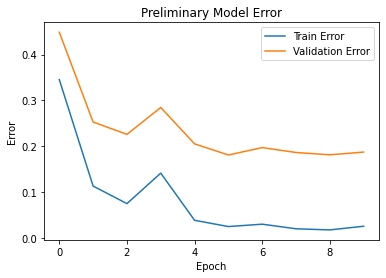

In [94]:
train_error = [
    0.3454204204204204,
    0.1131006006006006,
    0.0748123123123123,
    0.14136636636636637,
    0.03843843843843844,
    0.024737237237237236,
    0.02991741741741742,
    0.019857357357357358,
    0.017417417417417418,
    0.02545045045045045
]

train_loss = [
    1.9975641099911816,
    0.519983450196824,
    0.2568095434667929,
    0.1846058669517625,
    0.2003081373448642,
    0.10167069979152589, 
    0.07658512932511996,
    0.06751177927373715,
    0.06092002173393683,
    0.048539706382830186,
]
val_error = [
    0.4487876727849536,
    0.2528891910265126,
    0.2259234081123952,
    0.2846136415137095,
    0.20518921368683435,
    0.18094266938590528,
    0.19703149784726942,
    0.1863811466122819,
    0.1812825742125538,
    0.18728755948334466,
]

val_loss = [
    1.789199047618442,
    0.9529184301694235,
    0.8560722205373976,
    1.2405276364750333,
    0.8659322228696611,
    0.8551405800713433,
    0.9747237728701698,
    0.9954167770014869,
    1.0150667329629262,
    1.056118968460295

]

plt.plot(list(range(10)),train_error)
plt.plot(list(range(10)),val_error)
plt.legend(["Train Error", "Validation Error"])

plt.title("Preliminary Model Error")
plt.xlabel("Epoch")
plt.ylabel("Error")

Text(0, 0.5, 'Loss')

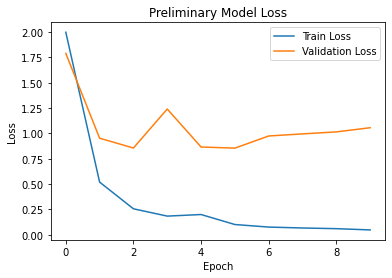

In [95]:
plt.plot(list(range(10)),train_loss)
plt.plot(list(range(10)),val_loss)
plt.legend(["Train Loss", "Validation Loss"])

plt.title("Preliminary Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [76]:
model = TrafficSignModelFeatures()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_loader, val_loader, test_loader = get_data_loader_features(512)

train_net(model, train_loader, val_loader, batch_size=512, learning_rate=0.006, num_epochs=10)

CUDA is available!  Training on GPU ...
Epoch 1: Train error: 0.3454204204204204, Train loss: 1.9975641099911816, Val error: 0.4487876727849536, Val loss: 1.789199047618442
Epoch 2: Train error: 0.1131006006006006, Train loss: 0.519983450196824, Val error: 0.2528891910265126, Val loss: 0.9529184301694235
Epoch 3: Train error: 0.0748123123123123, Train loss: 0.2568095434667929, Val error: 0.2259234081123952, Val loss: 0.8560722205373976
Epoch 4: Train error: 0.14136636636636637, Train loss: 0.1846058669517625, Val error: 0.2846136415137095, Val loss: 1.2405276364750333
Epoch 5: Train error: 0.03843843843843844, Train loss: 0.2003081373448642, Val error: 0.20518921368683435, Val loss: 0.8659322228696611
Epoch 6: Train error: 0.024737237237237236, Train loss: 0.10167069979152589, Val error: 0.18094266938590528, Val loss: 0.8551405800713433
Epoch 7: Train error: 0.02991741741741742, Train loss: 0.07658512932511996, Val error: 0.19703149784726942, Val loss: 0.9747237728701698
Epoch 8: Train

AttributeError: ignored

In [79]:
model_path = get_model_name("TrafficSignModelFeatures", 512, 0.006, 9)
plot_training_curve(model_path)


OSError: ignored

## Jordan just playing around to try to get a dataloader object
I'm using Lab 2 as a guide

Figuring out the structure of the dataset

In [ ]:
print(type(gtsrb_data))
print(gtsrb_data)
print(len(gtsrb_data))
print(gtsrb_data[10000][1])

Using some helper functions that I've slightly modified from Lab 2

In [ ]:
def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        # label_class = classes[label_index] # ex: 'cat'
        if label_index in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of signs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of ints denoting the index of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of ints denoting the index of each class
    """

    classes = tuple(range(0,43))
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load GTSRB training data
    trainset = torchvision.datasets.GTSRB(root='./data', split='train', transform=transform, download=True)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load GTSRB testing data
    testset = torchvision.datasets.GTSRB(root='./data', split='test', transform=transform, download=True)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

In [ ]:
classes = tuple(range(0,43))
target_classes = (0,)
print(type(classes[0]))
print(classes)
indices_class_0 = get_relevant_indices(gtsrb_data, classes, target_classes)
print(indices_class_0) # Now I have the indices in gtsrb_data of ClassId=0

# Get data loaders for training, validation, and test sets (images are only of ClassId=0)
train_loader, val_loader, test_loader, classes = get_data_loader(target_classes, batch_size=5)

In [ ]:
# Playing around with data loaders I created above
print(len(train_loader)) # There are 24 batches (5 images/batch) in the train loader -> This is 120 images which is 80% of 150!
print(len(val_loader)) # There are 6 batches (5 images/batch) in the val loader -> This is 30 images which is 20% of 150
print(len(test_loader)) # There are 12 batches (5 images/batch) in the test loader -> This is 60 images

Next I'll try to plot some of the images, just to see what we're working with

I don't think this is working because the images are of different sizes, we'll have to figure out what we're doing about this.

In [ ]:
k = 0
for images, labels in enumerate(train_loader):
    # since batch_size = 5, there are 5 images in 'images'
    for i in range(0,5):
      image = images[i]
      # place the colour channel at the end, instead of at the beginning
      img = np.transpose(image, [1,2,0])
      # normalize pixel intensity values to [0, 1]
      img = img / 2 + 0.5
      plt.subplot(3, 5, k+1)
      plt.axis('off')
      plt.imshow(img)

    k += 1
    if k > 14:
        break

**Helper Functions**

Will need functions to


*   Get model name (for training)
*   Evaluate network on validation set
*   Plot the training curves




**Define Model Architecture**

In [ ]:
class TrafficSignModel(nn.Module):
  def __init__(self):
     super(TrafficSignModel, self).__init__()
     self.name = "TrafficSignModel"
     self.conv1 = nn.Conv2d(3, 5, 5) # 3 input channels, 5 output channels, kernel size of 5
     self.pool = nn.MaxPool2d(2, 2), # kernel size of 2, stride of 2
     self.conv2 = nn.Conv2d(5, 10, 5), # 5 input channels, 10 output channels, kernel size of 5
     self.fc1 = nn.Linear() # Will need to figure out these dimensions (based on input dimensions of image - how are we handling this?)
     self.fc2 = nn.Linear() # Will need to figure out these dimensions (based on how many different classes we are working with - do we know?)
         
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, ) # Will need to figure out these dimensions - see above
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = x.squeeze(1) # Flatten to [batch_size]
    return x

**Training**

Function to train the neural network
Need to decide loss function and optimizer

A lot of this code can be adopted from the Labs and tutorials

## Katherine trying to augment the data

In [ ]:
augmented_datasets = []

my_transform = transforms.Compose([
    transforms.RandomRotation(25),
    transforms.ToTensor(),
])

for _ in range(2):
    gtsrb_new = datasets.GTSRB('data', download=True, transform=my_transform)
    augmented_datasets.append(gtsrb_new)

concat = torch.utils.data.ConcatDataset(augmented_datasets)

In [26]:
# mount our Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('drive/MyDrive/APS360/Project/SyRa-Synthesized_Rain_dataset-main')

In [ ]:
os.listdir("assets/folder_of_your_data/folder_of_your_data/")

In [ ]:
img.shape

In [ ]:
#train_data = get_train_data_loader(img_size=256)

for i, data in enumerate(train_data):
  img, label = data
  for j in range(img.shape[0]):
      torchvision.utils.save_image(img[j,:,:,:], 'assets/folder_of_your_data/folder_of_your_data/{}{}.png'.format(i,j))
  if i>=0:
    break

In [ ]:
!pip install munch

In [ ]:
!pip install ffmpeg

In [ ]:
import munch
import ffmpeg
import os

In [ ]:
os.chdir('drive/MyDrive/APS360/Project/SyRa-Synthesized_Rain_dataset-main')

In [ ]:
%%shell
python main.py --img_size 256 --mode syn --checkpoint_dir expr/checkpoint/SyRa --out_dir expr/result --data folder_of_your_data --resume_iter 100000